[kaggle](https://www.kaggle.com/c/landmark-recognition-challenge/overview)

Did you ever go through your vacation photos and ask yourself: What is the name of this temple I visited in China? Who created this monument I saw in France? Landmark recognition can help! This technology can predict landmark labels directly from image pixels, to help people better understand and organize their photo collections.

Today, a great obstacle to landmark recognition research is the lack of large annotated datasets. In this file, we will deal with the largest worldwide dataset to date, to foster progress in this problem. We will build models that recognize the correct landmark (if any) in a dataset of test images.

We are familiar with image classification challenges like the ImageNet Large Scale Visual Recognition Challenge (ILSVRC), which aims to recognize 1K general object categories. Landmark recognition is a little different from that: it contains a much larger number of classes (there are a total of 15K classes), and the number of training examples per class may not be very large. Landmark recognition is challenging in its own way.

This project is in conjunction with the Landmark Retrieval project ( https://www.kaggle.com/c/landmark-retrieval-challenge ). In particular, note that the test set for both projects is the same, to encourage participants to compete in both. We also encourage participants to use the training data from the recognition challenge to train models which could be useful for the retrieval challenge. Note, however, that there are no landmarks in common between the training/index sets of the two projects.

2019 challenge launched: https://kaggle.com/c/landmark-recognition-2019

### Data Description

Note: Since this challenge is finalized, the data files **(test.csv and train.csv)** were transferred to the [Google-Landmarks dataset webpage](https://www.kaggle.com/google/google-landmarks-dataset).

In this project, we are asked to take test images and recognize which landmarks (if any) are depicted in them. The test images are listed in `test.csv`, while `train.csv` contains a large number of images labeled with their associated landmarks. Test images may depict no landmark, one landmark, or more than one landmark. The training set images each depict exactly one landmark. Each image has a unique id (a hash) and each landmark has a unique id (an integer).

Due to restrictions on distributing the actual files, the dataset contains a **url** for each image (this [Python script](https://www.kaggle.com/tobwey/landmark-recognition-challenge-image-downloader) may be useful to download the images). Since these images are not directly in our control, a small percentage of them will be unavailable (and the availability may change over time). To account for this, we will download the images and adjust the solution file to ignore any missing test images.

We should expect this project to involve a small amount of leakage on account of image metadata. The hosts have intentionally selected images that do not contain geolocation information, but there may be predictive information present in the Exif data. Since Kaggle cannot detect whether this metadata is being used, consider its use to be permitted.

### Dataset construction
The training set was constructed by clustering photos with respect to their geolocation and visual similarity using an algorithm similar to the one described in `[1]`. Matches between training images were established using local feature matching. Note that there may be multiple clusters per landmark, which typically correspond to different views or different parts of the landmark. To avoid bias, no computer vision algorithms were used for ground truth generation. Instead, we established ground truth correspondences between test images and landmarks using human annotators.

`[1]` Y.-T. Zheng, M. Zhao, Y. Song, H. Adam, U. Buddemeier, A. Bissacco, F. Brucher T.-S. Chua, and H. Neven, “Tour the World: Building a Web-Scale Landmark Recognition Engine,” Proc. CVPR’09

### File descriptions
* `train.csv` - the training image set
* `test.csv` - the test set containing the test images for which you may predict landmarks
* `sample_submission.csv` - a sample submission file in the correct format

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline 

In [3]:
train_df = pd.read_csv('landmark-recognition/train.csv')
test_df = pd.read_csv('landmark-recognition/test.csv')
submission = pd.read_csv('landmark-recognition/sample_submission.csv')

In [4]:
print("Train data shape -  rows:",train_df.shape[0]," columns:", train_df.shape[1])
print("Test data size -  rows:",test_df.shape[0]," columns:", test_df.shape[1])

Train data shape -  rows: 1225029  columns: 3
Test data size -  rows: 117703  columns: 2


In [5]:
train_df.head()

,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231


In [6]:
test_df.head()

,id,url
0,000088da12d664db,https://lh3.googleusercontent.com/-k45wfamuhT8...
1,0001623c6d808702,https://lh3.googleusercontent.com/-OQ0ywv8KVIA...
2,0001bbb682d45002,https://lh3.googleusercontent.com/-kloLenz1xZk...
3,0002362830cfe3a3,https://lh3.googleusercontent.com/-N6z79jNZYTg...
4,000270c9100de789,https://lh3.googleusercontent.com/-keriHaVOq1U...


In [7]:
submission.head()

,id,landmarks
0,000088da12d664db,8815 0.03
1,0001623c6d808702,7249 0.61
2,0001bbb682d45002,5328 0.5
3,0002362830cfe3a3,4188 0.96
4,000270c9100de789,10506 0.82


In [8]:
# missing data in training data set
missing = train_df.isnull().sum()
all_val = train_df.count()

missing_train_df = pd.concat([missing, all_val], axis=1, keys=['Missing', 'All'])
missing_train_df

,Missing,All
id,0,1225029
url,0,1225029
landmark_id,0,1225029


In [9]:
# missing data in training data set
missing = test_df.isnull().sum()
all_val = test_df.count()

missing_test_df = pd.concat([missing, all_val], axis=1, keys=['Missing', 'All'])
missing_test_df

,Missing,All
id,0,117703
url,0,117703


In [10]:
train_df.nunique()

id             1225029
url            1225029
landmark_id      14951
dtype: int64

In [11]:
test_df.nunique()

id     117703
url    117703
dtype: int64

In [12]:
# concatenate train and test datasets
concatenated = pd.concat([train_df, test_df])
# print the shape of the resulted data.frame
concatenated.shape

(1342732, 3)

In [13]:
concatenated.nunique()

id             1342732
url            1342732
landmark_id      14951
dtype: int64

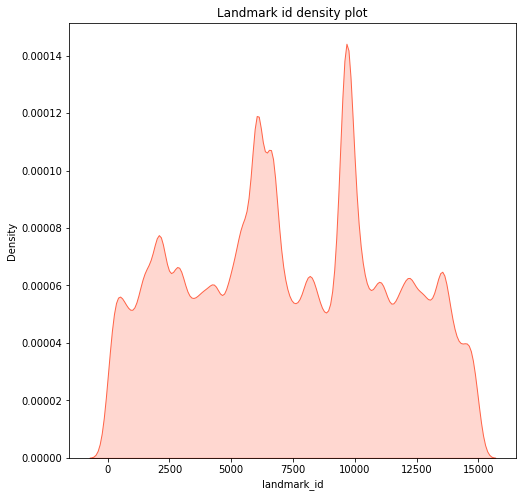

In [14]:
plt.figure(figsize = (8, 8))
plt.title('Landmark id density plot')
sns.kdeplot(train_df['landmark_id'], color="tomato", shade=True)
plt.show()

C:\Users\Waqas.Ali\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


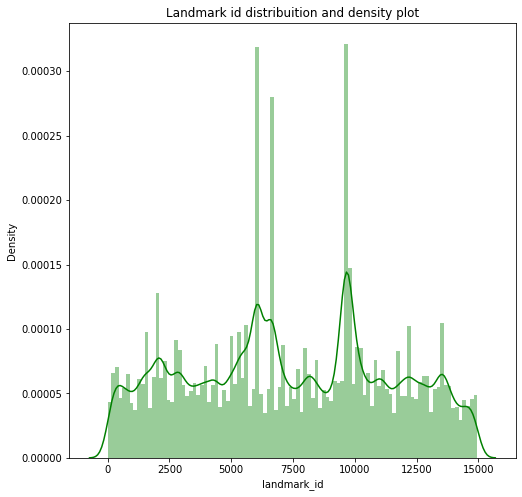

In [15]:
plt.figure(figsize = (8, 8))
plt.title('Landmark id distribuition and density plot')
sns.distplot(train_df['landmark_id'],color='green', kde=True,bins=100)
plt.show()

In [16]:
th10 = pd.DataFrame(train_df.landmark_id.value_counts().head(10))
th10.reset_index(level=0, inplace=True)
th10.columns = ['landmark_id','count']
th10

,landmark_id,count
0,9633,50337
1,6051,50148
2,6599,23415
3,9779,18471
4,2061,13271
5,5554,11147
6,6651,9508
7,6696,9222
8,5376,9216
9,2743,8997


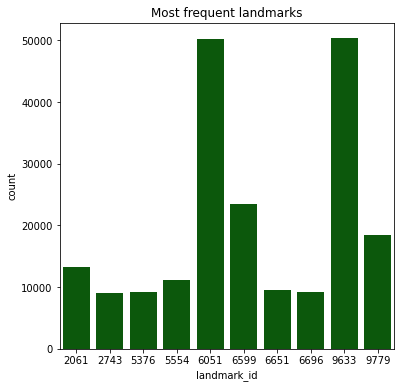

In [17]:
# Plot the most frequent landmark occurences
plt.figure(figsize = (6, 6))
plt.title('Most frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=th10,
            label="Count", color="darkgreen")
plt.show()

In [18]:
tb10 = pd.DataFrame(train_df.landmark_id.value_counts().tail(10))
tb10.reset_index(level=0, inplace=True)
tb10.columns = ['landmark_id','count']
tb10

,landmark_id,count
0,13031,1
1,123,1
2,5745,1
3,2395,1
4,1865,1
5,12452,1
6,10007,1
7,5581,1
8,6069,1
9,9265,1


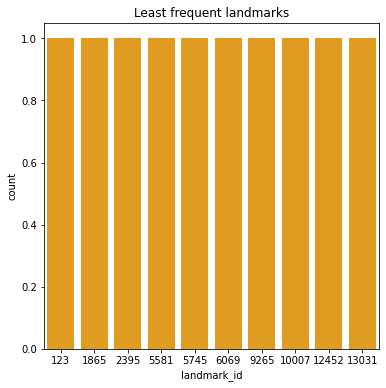

In [19]:
# Plot the least frequent landmark occurences
plt.figure(figsize = (6,6))
plt.title('Least frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=tb10,
            label="Count", color="orange")
plt.show()

In [20]:
# Extract repositories names for train data
ll = list()
for path in train_df['url']:
    ll.append((path.split('//', 1)[1]).split('/', 1)[0])
train_df['site'] = ll
# Extract repositories names for test data
ll = list()
for path in test_df['url']:
    ll.append((path.split('//', 1)[1]).split('/', 1)[0])
test_df['site'] = ll

In [21]:
print("Train data shape -  rows:",train_df.shape[0]," columns:", train_df.shape[1])
print("Test data size -  rows:",test_df.shape[0]," columns:", test_df.shape[1])

Train data shape -  rows: 1225029  columns: 4
Test data size -  rows: 117703  columns: 3


In [22]:
train_df.head()

,id,url,landmark_id,site
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676,static.panoramio.com
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651,lh6.ggpht.com
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284,lh6.ggpht.com
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429,lh3.googleusercontent.com
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231,lh5.googleusercontent.com


In [23]:
test_df.head()

,id,url,site
0,000088da12d664db,https://lh3.googleusercontent.com/-k45wfamuhT8...,lh3.googleusercontent.com
1,0001623c6d808702,https://lh3.googleusercontent.com/-OQ0ywv8KVIA...,lh3.googleusercontent.com
2,0001bbb682d45002,https://lh3.googleusercontent.com/-kloLenz1xZk...,lh3.googleusercontent.com
3,0002362830cfe3a3,https://lh3.googleusercontent.com/-N6z79jNZYTg...,lh3.googleusercontent.com
4,000270c9100de789,https://lh3.googleusercontent.com/-keriHaVOq1U...,lh3.googleusercontent.com


In [24]:
train_site = pd.DataFrame(train_df.site.value_counts())
test_site = pd.DataFrame(test_df.site.value_counts())

In [25]:
train_site

,site
lh3.googleusercontent.com,182010
lh4.googleusercontent.com,177774
lh5.googleusercontent.com,175251
lh6.googleusercontent.com,171506
lh3.ggpht.com,105043
lh4.ggpht.com,102460
lh6.ggpht.com,102066
lh5.ggpht.com,100905
mw2.google.com,94947
static.panoramio.com,12468


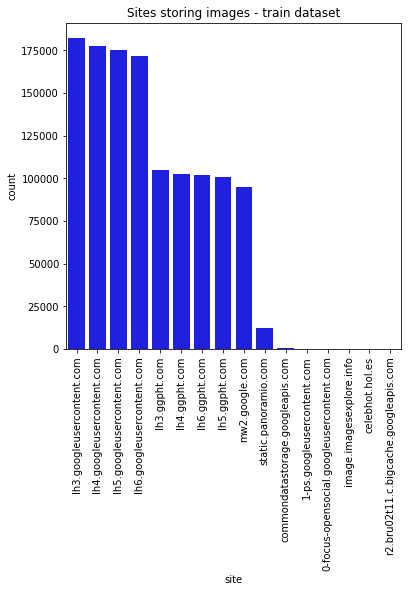

In [26]:
trsite = pd.DataFrame(list(train_site.index),train_site['site'])
trsite.reset_index(level=0, inplace=True)
trsite.columns = ['count','site']
plt.figure(figsize = (6,6))
plt.title('Sites storing images - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'site', y="count", data=trsite, color="blue")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [27]:
test_site

,site
lh3.googleusercontent.com,116855
lh3.ggpht.com,166
lh5.ggpht.com,134
lh4.ggpht.com,123
images1-focus-opensocial.googleusercontent.com,102
lh6.ggpht.com,92
lh5.googleusercontent.com,80
lh4.googleusercontent.com,55
static.panoramio.com,47
lh6.googleusercontent.com,28


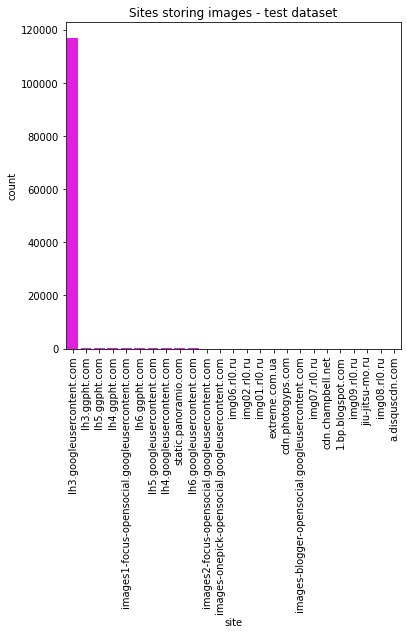

In [28]:
tesite = pd.DataFrame(list(test_site.index),test_site['site'])
tesite.reset_index(level=0, inplace=True)
tesite.columns = ['count','site']
plt.figure(figsize = (6,6))
plt.title('Sites storing images - test dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'site', y="count", data=tesite, color="magenta")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [29]:
def displayLandmark(urls, landmarkName):
    
    img_style = "height: 60px; margin: 2px; float: left; border: 1px solid blue;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.iteritems()])

    display(HTML(images_list))

In [30]:
IMAGES_NUMBER = 60
landmarkId = train_df['landmark_id'].value_counts().keys()[5]
urls = train_df[train_df['landmark_id'] == landmarkId]['url'].head(IMAGES_NUMBER)
displayLandmark(urls, "Petronas")

In [31]:
urls.head(1)

86    https://lh3.googleusercontent.com/-EpNtXQntMr0...
Name: url, dtype: object

In [32]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

In [33]:
class ImageMetaData(object):
    '''
    Extract the exif data from any image. Data includes GPS coordinates, 
    Focal Length, Manufacture, and more.
    '''
    exif_data = None
    image = None

    def __init__(self, img_path):
        self.image = Image.open(img_path)
        print(self.image._getexif())
        #self.get_exif_data()
        #super(ImageMetaData, self).__init__()

    def get_exif_data(self):
        """Returns a dictionary from the exif data of an PIL Image item. Also converts the GPS Tags"""
        exif_data = {}
        info = self.image._getexif()
        if info:
            for tag, value in info.items():
                decoded = TAGS.get(tag, tag)
                if decoded == "GPSInfo":
                    gps_data = {}
                    for t in value:
                        sub_decoded = GPSTAGS.get(t, t)
                        gps_data[sub_decoded] = value[t]

                    exif_data[decoded] = gps_data
                else:
                    exif_data[decoded] = value
        self.exif_data = exif_data
        return exif_data

    def get_if_exist(self, data, key):
        if key in data:
            return data[key]
        return None

    def convert_to_degress(self, value):

        """Helper function to convert the GPS coordinates 
        stored in the EXIF to degress in float format"""
        d0 = value[0][0]
        d1 = value[0][1]
        d = float(d0) / float(d1)

        m0 = value[1][0]
        m1 = value[1][1]
        m = float(m0) / float(m1)

        s0 = value[2][0]
        s1 = value[2][1]
        s = float(s0) / float(s1)

        return d + (m / 60.0) + (s / 3600.0)

    def get_lat_lng(self):
        """Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)"""
        lat = None
        lng = None
        exif_data = self.get_exif_data()
        #print(exif_data)
        if "GPSInfo" in exif_data:      
            gps_info = exif_data["GPSInfo"]
            gps_latitude = self.get_if_exist(gps_info, "GPSLatitude")
            gps_latitude_ref = self.get_if_exist(gps_info, 'GPSLatitudeRef')
            gps_longitude = self.get_if_exist(gps_info, 'GPSLongitude')
            gps_longitude_ref = self.get_if_exist(gps_info, 'GPSLongitudeRef')
            if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
                lat = self.convert_to_degress(gps_latitude)
                if gps_latitude_ref != "N":                     
                    lat = 0 - lat
                lng = self.convert_to_degress(gps_longitude)
                if gps_longitude_ref != "E":
                    lng = 0 - lng
        return lat, lng

In [34]:
# # submit the most freq label
# submission['landmarks'] = '%d %2.2f' % (freq_label.index[0], freq_label.values[0])
# submission.to_csv('submission.csv', index=False)

# np.random.seed(2018)
# r_idx = lambda : np.random.choice(freq_label.index, p = freq_label.values)

# r_score = lambda idx: '%d %2.4f' % (freq_label.index[idx], freq_label.values[idx])
# submission['landmarks'] = submission.id.map(lambda _: r_score(r_idx()))
# submission.to_csv('rand_submission.csv', index=False)

In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [38]:
train_data = pd.read_csv('landmark-recognition/train.csv')
test_data = pd.read_csv('landmark-recognition/test.csv')
submission = pd.read_csv('landmark-recognition/sample_submission.csv')

In [39]:
print("Training data size",train_data.shape)
print("test data size",test_data.shape)
submission.head()

Training data size (1225029, 3)
test data size (117703, 2)


,id,landmarks
0,000088da12d664db,8815 0.03
1,0001623c6d808702,7249 0.61
2,0001bbb682d45002,5328 0.5
3,0002362830cfe3a3,4188 0.96
4,000270c9100de789,10506 0.82


In [40]:
test_data.head()

,id,url
0,000088da12d664db,https://lh3.googleusercontent.com/-k45wfamuhT8...
1,0001623c6d808702,https://lh3.googleusercontent.com/-OQ0ywv8KVIA...
2,0001bbb682d45002,https://lh3.googleusercontent.com/-kloLenz1xZk...
3,0002362830cfe3a3,https://lh3.googleusercontent.com/-N6z79jNZYTg...
4,000270c9100de789,https://lh3.googleusercontent.com/-keriHaVOq1U...


In [41]:
# now open the URL
temp = 4444
print('id', train_data['id'][temp])
print('url:', train_data['url'][temp])
print('landmark id:', train_data['landmark_id'][temp])

id a6c207c04d7c3835
url: https://lh5.googleusercontent.com/-oJsiYZW1JPE/Rnah5Zf5XxI/AAAAAAAAADY/tLtMU5hCdlI/s1600/
landmark id: 233


<AxesSubplot:>

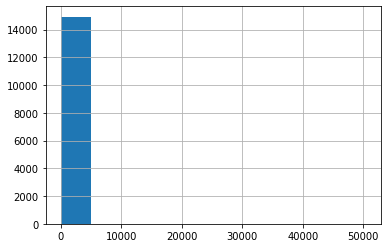

In [42]:
train_data['landmark_id'].value_counts().hist()

In [43]:
# missing data in training data 
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending = False)
missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
id,0,0.0
url,0,0.0
landmark_id,0,0.0


In [44]:
# missing data in test data 
total = test_data.isnull().sum().sort_values(ascending = False)
percent = (test_data.isnull().sum()/test_data.isnull().count()).sort_values(ascending = False)
missing_test_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_test_data.head()

,Total,Percent
id,0,0.0
url,0,0.0


In [45]:
# Occurance of landmark_id in decreasing order(Top categories)
temp = pd.DataFrame(train_data.landmark_id.value_counts().head(8))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp

,landmark_id,count
0,9633,50337
1,6051,50148
2,6599,23415
3,9779,18471
4,2061,13271
5,5554,11147
6,6651,9508
7,6696,9222


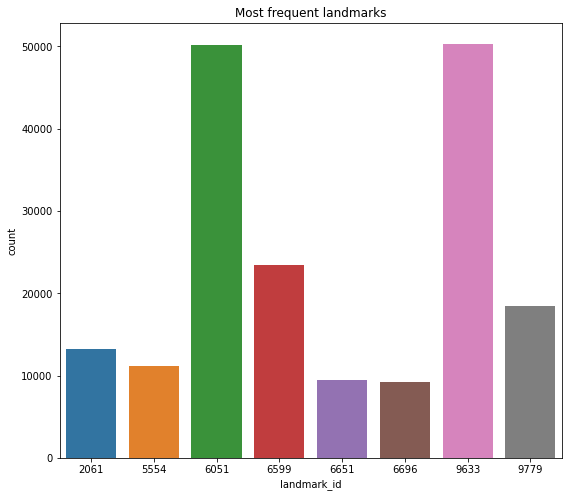

In [46]:
# Plot the most frequent landmark_ids
plt.figure(figsize = (9, 8))
plt.title('Most frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,
            label="Count")
plt.show()

In [47]:
# Occurance of landmark_id in increasing order
temp = pd.DataFrame(train_data.landmark_id.value_counts().tail(8))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp

,landmark_id,count
0,5745,1
1,2395,1
2,1865,1
3,12452,1
4,10007,1
5,5581,1
6,6069,1
7,9265,1


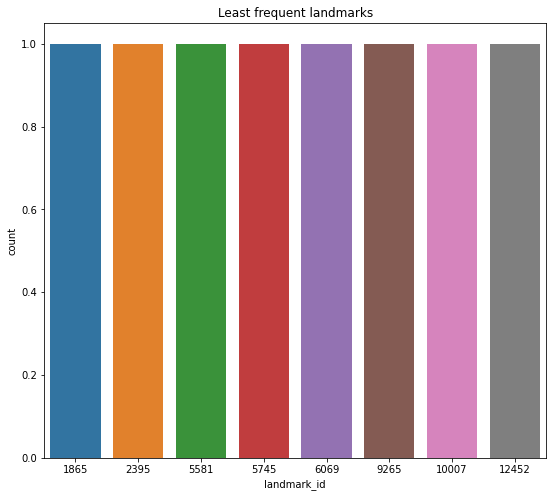

In [48]:
# Plot the least frequent landmark_ids
plt.figure(figsize = (9, 8))
plt.title('Least frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,
            label="Count")
plt.show()

In [49]:
# Unique URL's
train_data.nunique()

id             1225029
url            1225029
landmark_id      14951
dtype: int64

C:\Users\Waqas.Ali\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


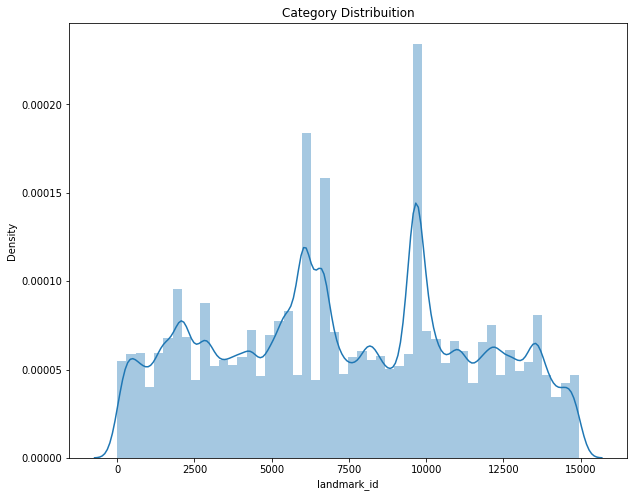

In [50]:
#Class distribution
plt.figure(figsize = (10, 8))
plt.title('Category Distribuition')
sns.distplot(train_data['landmark_id'])

plt.show()

In [51]:
print("Number of classes under 20 occurences",(train_data['landmark_id'].value_counts() <= 20).sum(),'out of total number of categories',len(train_data['landmark_id'].unique()))

Number of classes under 20 occurences 8797 out of total number of categories 14951


In [52]:
from IPython.display import Image
from IPython.core.display import HTML 

def display_category(urls, category_name):
    img_style = "width: 180px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(12).iteritems()])

    display(HTML(images_list))


In [53]:
category = train_data['landmark_id'].value_counts().keys()[0]
urls = train_data[train_data['landmark_id'] == category]['url']
display_category(urls, "")

In [54]:
# Extract site_names for train data
temp_list = list()
for path in train_data['url']:
    temp_list.append((path.split('//', 1)[1]).split('/', 1)[0])
train_data['site_name'] = temp_list
# Extract site_names for test data
temp_list = list()
for path in test_data['url']:
    temp_list.append((path.split('//', 1)[1]).split('/', 1)[0])
test_data['site_name'] = temp_list

In [55]:
print("Training data size",train_data.shape)
print("test data size",test_data.shape)

Training data size (1225029, 4)
test data size (117703, 3)


In [56]:
train_data.head(8)

,id,url,landmark_id,site_name
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676,static.panoramio.com
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651,lh6.ggpht.com
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284,lh6.ggpht.com
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429,lh3.googleusercontent.com
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231,lh5.googleusercontent.com
5,2c9c54b62f0a6a37,https://lh5.googleusercontent.com/-mEaSECO7D-4...,10400,lh5.googleusercontent.com
6,0aac70a1de44ced6,http://lh6.ggpht.com/-cJMh9AYQGk8/SOkF_Q5PrjI/...,9779,lh6.ggpht.com
7,de770bc720f8e714,https://lh4.googleusercontent.com/-Q_FvRlwaaa8...,11288,lh4.googleusercontent.com


In [57]:
test_data.head()

,id,url,site_name
0,000088da12d664db,https://lh3.googleusercontent.com/-k45wfamuhT8...,lh3.googleusercontent.com
1,0001623c6d808702,https://lh3.googleusercontent.com/-OQ0ywv8KVIA...,lh3.googleusercontent.com
2,0001bbb682d45002,https://lh3.googleusercontent.com/-kloLenz1xZk...,lh3.googleusercontent.com
3,0002362830cfe3a3,https://lh3.googleusercontent.com/-N6z79jNZYTg...,lh3.googleusercontent.com
4,000270c9100de789,https://lh3.googleusercontent.com/-keriHaVOq1U...,lh3.googleusercontent.com


In [58]:
# Occurance of site in decreasing order(Top categories)
temp = pd.DataFrame(train_data.site_name.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['site_name','count']
temp

,site_name,count
0,lh3.googleusercontent.com,182010
1,lh4.googleusercontent.com,177774
2,lh5.googleusercontent.com,175251
3,lh6.googleusercontent.com,171506
4,lh3.ggpht.com,105043
5,lh4.ggpht.com,102460
6,lh6.ggpht.com,102066
7,lh5.ggpht.com,100905
8,mw2.google.com,94947
9,static.panoramio.com,12468


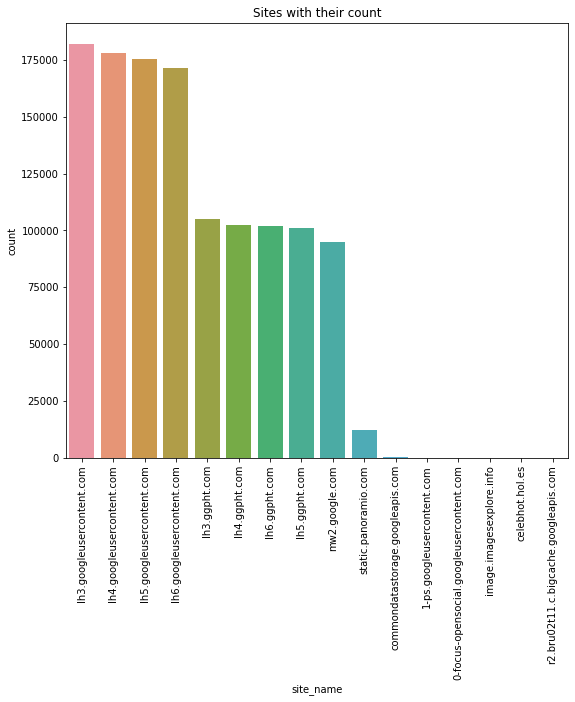

In [59]:
# Plot the Sites with their count
plt.figure(figsize = (9, 8))
plt.title('Sites with their count')
sns.set_color_codes("pastel")
sns.barplot(x="site_name", y="count", data=temp,
            label="Count")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [60]:
# Occurance of site in decreasing order(Top categories)
temp = pd.DataFrame(test_data.site_name.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['site_name','count']
temp

,site_name,count
0,lh3.googleusercontent.com,116855
1,lh3.ggpht.com,166
2,lh5.ggpht.com,134
3,lh4.ggpht.com,123
4,images1-focus-opensocial.googleusercontent.com,102
5,lh6.ggpht.com,92
6,lh5.googleusercontent.com,80
7,lh4.googleusercontent.com,55
8,static.panoramio.com,47
9,lh6.googleusercontent.com,28


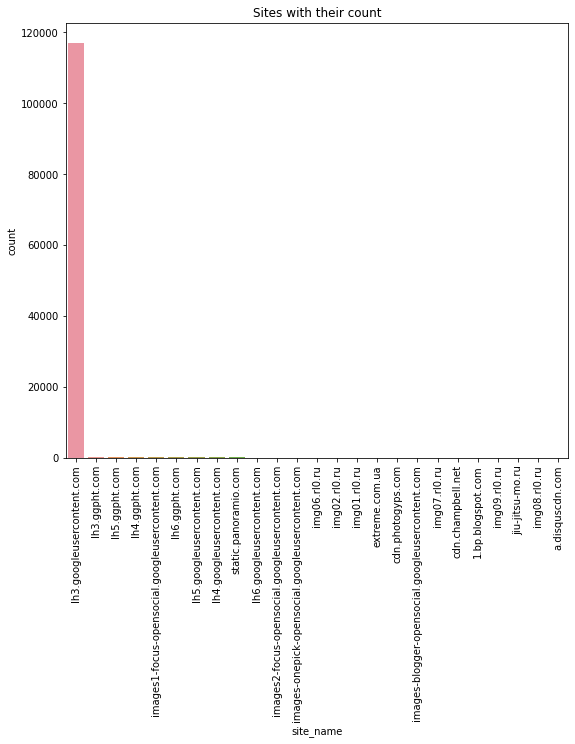

In [61]:
# Plot the Sites with their count
plt.figure(figsize = (9, 8))
plt.title('Sites with their count')
sns.set_color_codes("pastel")
sns.barplot(x="site_name", y="count", data=temp,
            label="Count")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [62]:
# take the most frequent label
freq_label = train_df['landmark_id'].value_counts()/train_df['landmark_id'].value_counts().sum()

# submit the most freq label
submission['landmarks'] = '%d %2.2f' % (freq_label.index[0], freq_label.values[0])
submission.to_csv('submission.csv', index=False)

np.random.seed(2018)
r_idx = lambda : np.random.choice(freq_label.index, p = freq_label.values)

r_score = lambda idx: '%d %2.4f' % (freq_label.index[idx], freq_label.values[idx])
submission['landmarks'] = submission.id.map(lambda _: r_score(r_idx()))
submission.to_csv('rand_submission.csv', index=False)